# Classification Avancée
# TP 4 
## Séparateur à Vaste Marge et Méthode à Noyaux


## Machines à Vecteurs de Support (SVM)

On commence par (essayer... d') installer un module qui permet de plus jolies visualisation que le matplotlib de base:

In [3]:
!pip3 install seaborn --user

## Première partie : prise en main des SVM
Cette partie est librement inspirée du travail de Jake VenderPlas, auteur du livre [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do). Son [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook) (en anglais) regorge de fichiers utiles.

Dans un premier temps, on va générer des données jouets, linéairement séparables :

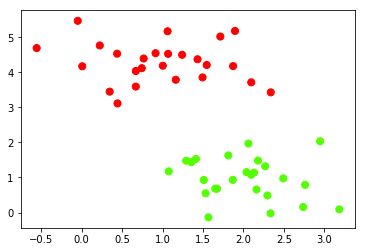

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

#Un petit environment qui donne de meilleurs graphes
#import seaborn as sns; sns.set()

# fonction sklearn pour générer des données simples
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

# Affichage des données
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism');

### SVM linéaire (=perceptron à vaste marge)
On va commencer par apprendre un SVM sans noyau (on dit "linéaire") à l'aide de scikit-learn :

In [5]:
#import de la classe - qui s'appelle SVC et pas SVM...
from sklearn.svm import SVC
#Définition du modèle
model = SVC(kernel='linear', C=1E10)
#Apprentissage sur les donnée
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

On va utiliser une fonction d'affichage qui va bien, où tout ce qui est nécessaire est affiché. Il ne faut pas forcément la comprendre complètement de suite car on reviendra plus bas sur les points importants.

In [6]:
import numpy as np

def affiche_fonction_de_decision(model, ax=None, plot_support=True):
    """Affiche le séparateur, les marges, et les vecteurs de support d'un SVM en 2D"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # création de la grille pour l'évaluation
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # affichage de l'hyperplan et des marges
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # Affichage des vecteurs de support
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolor='black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

Voyons ce que cela donne sur notre séparateur linéaire à vaste marge :

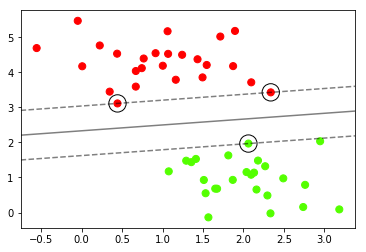

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')
affiche_fonction_de_decision(model);

Sur ce graphe, on voit le séparateur (ligne pleine), les vecteurs de support (points entourés) et la marge (matérialisée par des lignes discontinues).
On a ici le séparateur qui maximise la marge.
Scikit-learn nous permet, après apprentissage, de récupérer les vecteurs de supports:

In [8]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Seuls trois données sont utiles pour classer de nouvelles données. On peut s'en assurer en rajoutant des données sans changer le modèle :


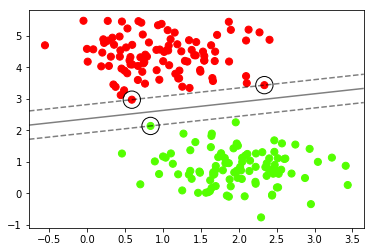

In [9]:
X2, y2 = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=0.60)

model2 = SVC(kernel='linear', C=1E10)
model2.fit(X2, y2)

plt.scatter(X2[:, 0], X2[:, 1], c=y2, s=50, cmap='prism')
affiche_fonction_de_decision(model2);

### SVM non linéaire
Comme on l'a vu ce matin, la puissance des séparateurs linéaires est limitée (à des données linéairement séparables). Mais il est possible de contourner cette limitation par l'utilisation de noyaux.

On va commencer par générer des données non-linéairement séparables :

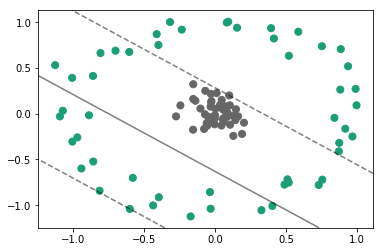

In [10]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Dark2')
affiche_fonction_de_decision(clf, plot_support=False)

Clairement notre apprentissage de séparateur linéaire a échoué...

On va manuellement ajouter une troisième dimension *z* :

In [11]:
z = np.exp(-(X ** 2).sum(1))

On peut afficher les données augmentées et se rendre compte qu'elles sont linéairement séparables :

Text(0.5, 0, 'z')

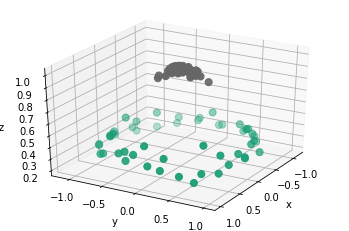

In [12]:
from mpl_toolkits.mplot3d import Axes3D
ax = plt.subplot(projection='3d')
ax.scatter3D(X[:, 0], X[:, 1], z, c=y, s=50, cmap='Dark2')
ax.view_init(elev=30, azim=30)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Le plan définit par z=0.7 (par exemple) sépare les 2 classes parfaitement.

Bien entendu, la projection en plus grande dimension est capitale, et en choisissant un autre calcul pour *z* on aurait obtenu dans la plupart des cas des données non linéairement séparables.

Et s'il fallait faire effectivement la projection, cela limiterait drastiquement la dimension de l'espace de plongement ainsi que le nombre de données traitables. C'est pourquoi l'utilisation de noyaux (kernels en anglais) est d'une grande efficacité.

En Scikit-Learn, il suffit de modifier le paramètre *kernel* : jusqu'à présent, nous avons utilisé 'linear' comme valeur. On peut par exemple utiliser *rbf* pour 'radial basis function', le noyau gaussien, et il nous reste à trouver la bonne valeur du paramètre :

In [13]:
clf = SVC(kernel='rbf', gamma='auto', C=1E10)
clf.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

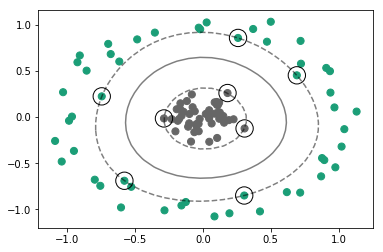

In [14]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='Dark2')
affiche_fonction_de_decision(clf) 

On voit ici que le séparateur (et la marge associée) ne sont pas linéaire dans l'espace des données, mais qu'ils peuvent s'y représenter sans difficulté.

Notons aussi que le nombre de vecteurs de support reste très petit.

### SVM à marge douce

Il est aussi possible que le problème soit linéairement séparable (dans la dimension initiale des données ou dans un plongement) mais que le bruit (=la mauvaise qualité des données) empêche l'apprenant de trouver un séparateur.

On utilise alors ce que l'on appelle un classifieur à marge douce : on autorise alors certains points à être dans la marge. C'est le role du paramètre *C* : pour des grosses valeurs, on est quasiment en marge dure, mais plus *C* prend des petites valeurs, plus les marges deviennent permissibles.

On va prendre des données qui se chevauchent un peu :

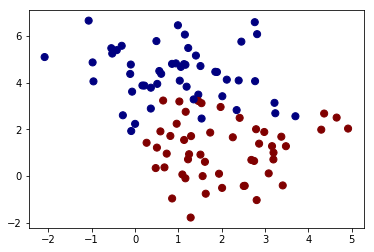

In [14]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet');

On joue alors avec la valeur de *C*

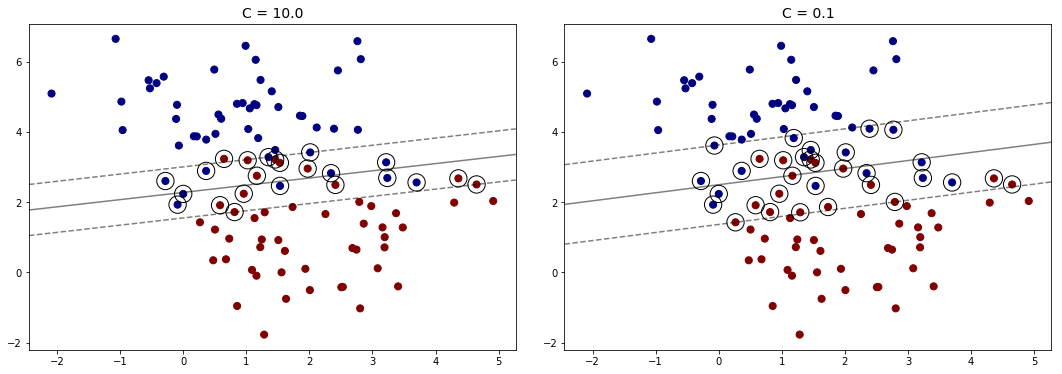

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    affiche_fonction_de_decision(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Bien entendu, il est possible de combiner l'utilisation d'un noyau et de marges douces.

### Tuner un SVM
Tous les noyaux sont paramétrés : il est question ici d'étudier l'impact d'un (hyper)paramètre sur la qualité de l'apprentissage.
On va générer des données qui ne sont pas linéairement séparables :

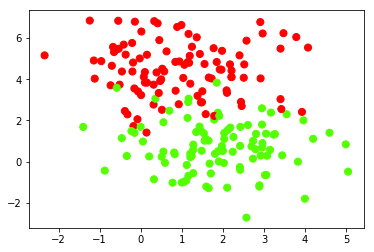

In [16]:
X, y = make_blobs(n_samples=200, centers=2,
                  random_state=0, cluster_std=1.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')

On va étudier 2 noyaux différents
- le noyau polynomial (*kernel='poly'*) qui a 2 paramètres, *degree* qu'il faut faire varier entre 2 et 6 (au minimum), et *C* (lié à la 'douceur' de la marge)
- le noyau gaussien (*kernel='rbf'*) qui a aussi 2 paramètres, *gamma*, qu'il faut faire varier de 1 à 0.01, et *C* 

A chaque fois, en plus de l'affichage des séparateurs, il serait intéressant de regarder combien de vecteurs de support le classifieur appris a besoin.

A vous de jouer !


In [11]:
# A vous

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

In [18]:
####
from sklearn.model_selection import train_test_split
# production de deux sous-échantillons
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42) 

In [42]:

# trouver le bon parametre entre ces differents hyper parametres 
tuned_parameters = [{'kernel': ['poly'], 'degree': [2,3,4,5,6],'C': [1, 10, 100, 1000]},
                    {'kernel': ['rbf'], 'gamma':[1,0.5,0.1,0.05,0.01],'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,  scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()   


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

Grid scores on development set:

0.920 (+/-0.109) for {'C': 1, 'degree': 2, 'kernel': 'poly'}
0.919 (+/-0.082) for {'C': 1, 'degree': 3, 'kernel': 'poly'}
0.905 (+/-0.078) for {'C': 1, 'degree': 4, 'kernel': 'poly'}
0.885 (+/-0.095) for {'C': 1, 'degree': 5, 'kernel': 'poly'}
0.882 (+/-0.085) for {'C': 1, 'degree': 6, 'kernel': 'poly'}
0.920 (+/-0.109) for {'C': 10, 'degree': 2, 'kernel': 'poly'}
0.913 (+/-0.091) for {'C': 10, 'degree': 3, 'kernel': 'poly'}
0.897 (+/-0.100) for {'C': 10, 'degree': 4, 'kernel': 'poly'}
0.871 (+/-0.124) for {'C': 10, 'degree': 5, 'kernel': 'poly'}
0.882 (+/-0.085) for {'C': 10, 'degree': 6, 'kernel': 'poly'}
0.920 (+/-0.109) for {'C': 100, 'degree': 2, 'kernel': 'poly'}
0.904 (+/-0.113) for {'C': 100, 'degree': 3, 'kernel': 'poly'}
0.892 (+/-0.100) for {'C': 100, 'degree': 4, 'kernel': 'poly'}
0.878 (+/-0.106) for {'C': 100, 'd

In [ ]:
#Best parameters set found on development set:

#{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}

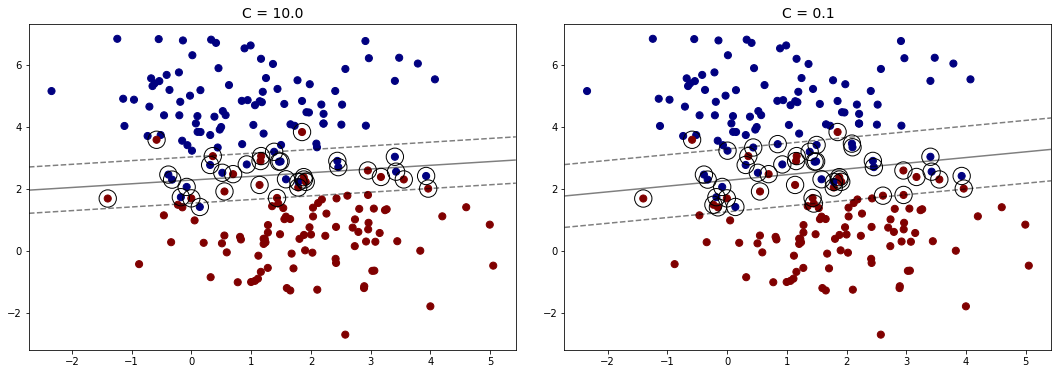

In [19]:

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='jet')
    affiche_fonction_de_decision(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Nombre de vecteurs de support (sur 200 données) : 50


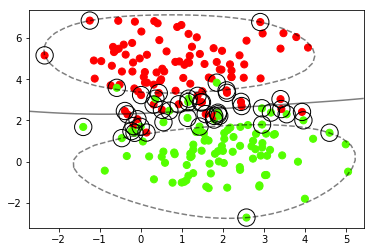

In [20]:
###
#E10
#Exemple avec le noyau gaussien et des valeurs pour gamma et C
clf = SVC(kernel='rbf', gamma=0.1, C=1)
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='prism')
affiche_fonction_de_decision(clf) 
print("Nombre de vecteurs de support (sur 200 données) :", len(clf.support_vectors_))

In [ ]:
#nombre de SVM 50 vecteurs

## Deuxième partie : un traitement (presque) complet
### Préparation des données
Nous allons utiliser un jeu de données réel - tiré de *Tsanas & Xifara : Accurate quantitative estimation of energy performance of residential buildings using statistical machine learning tools, Energy and Buildings, Vol. 49, pp. 560-567, 2012* - qu'il vous faut d'abord télécharger :

In [18]:
!wget http://pageperso.lif.univ-mrs.fr/~remi.eyraud/data.csv

--2018-12-10 21:52:35--  http://pageperso.lif.univ-mrs.fr/~remi.eyraud/data.csv
Resolving pageperso.lif.univ-mrs.fr (pageperso.lif.univ-mrs.fr)... 139.124.22.27
Connecting to pageperso.lif.univ-mrs.fr (pageperso.lif.univ-mrs.fr)|139.124.22.27|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39915 (39K) [text/csv]
Saving to: 'data.csv.4'

     0K .......... .......... .......... ........             100% 1.23M=0.03s

2018-12-10 21:52:35 (1.23 MB/s) - 'data.csv.4' saved [39915/39915]



Les 8 premières colonnes correspondent aux attributs descriptifs et les deux dernières, aux charges de chauffage et de climatisation (dans cet ordre).
Pour les utiliser en Python, vous pourrez vous servir du code suivant :

In [19]:
data = np.loadtxt("./data.csv")
X = data[:,:-2]
Y = data[:,-2:]
Yheat = Y[:,0]
Ycool = Y[:,1]

Le problème initial, tel que présenté ici, est un problème de régression. Nous allons d'abord le transformer en problème de classification. Par une méthode de clustering, on veut répartir les charges de chauffage et de climatisation en 3 classes : faibles, moyennes, élevées.

In [20]:
# Le seul trick : les Y sont des vecteurs et les classifieurs sklearn ont besoin d'array :
# il faut les reshaper : Yheat_vector = Yheat.reshape(-1,1)
Yheat_vector = Yheat.reshape(-1,1)
Ycool_vector = Ycool.reshape(-1,1)

A vous de jouer :

In [21]:
from sklearn.cluster import KMeans

# La suite ? il s'agit de définir un classifieur du k-means avec k=3 
# et d'utiliser la méthode 'fit' sur les 2 ensembles de valeurs Y

kmeans = KMeans(n_clusters=3)

y_cool=kmeans.fit (Ycool_vector).labels_
y_heat=kmeans.fit (Yheat_vector).labels_

y_kmeans = kmeans.fit(Ycool_vector,Yheat_vector).labels_
#kmeans.labels_


# Après apprentissage du kmeans, les classes des données utilisées sont stockées dans mon_classifieur.labels_

### Apprentissage
Nous voulons comparer plusieurs méthodes d'apprentissage :
1. Les k-plus proches voisins (*KNeighborsClassifier* de la classe *sklearn.neighbors*, hyperparamètre à régler : *n_neighbors*)
2. Les arbres de décision  (*DecisionTreeClassifier* de la classe *sklearn.tree*, hyperparamètre à régler : *max_depth*)
3. Perceptron linéaire (*Perceptron* de la classe *sklearn.linear_model*, hyperparamètre à régler : aucun/*max_iter* en sklearn 0.19 ou plus récent)
4. SVM à noyau gaussien  (*SVC* avec *kernel='rbf'* de la classe *sklearn.svm*, hyperparamètre à régler : *gamma*)
5. SVM à noyau polynomial (*SVC* avec *kernel='poly'* de la classe *sklearn.svm*, hyperparamètre à régler : *degree*)

Ecrivez le code permettant de :
1. Séparer les données en un échantillon d'apprentissage et un échantillon de test (80/20)

2. Sélectionner les meilleurs valeurs des hyperparamètres sur l'échantillon d'apprentissage par validation croisée en utilisant 10 folders



In [22]:
# separation des données 80/20
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y_kmeans,test_size=0.20, random_state=42) 


In [23]:
#Apprentissage trouver les bons params
from sklearn.model_selection import GridSearchCV
#1 Les k-plus proches voisins n_neighbors

from sklearn import neighbors as nn
import numpy as np

n = np.arange(1,126,1)
tuned_parameters = [{'n_neighbors': n}]
clf_knn = GridSearchCV(nn.KNeighborsClassifier(), tuned_parameters, cv=10)
clf_knn.fit(X_train, y_train)
print("Best parameters set found on development set knn:")
print(clf_knn.best_params_)


Best parameters set found on development set knn:
{'n_neighbors': 4}


In [24]:
#2Les arbres de décision  *DecisionTreeClassifier*  max_depth

from sklearn.tree import DecisionTreeClassifier
import numpy as np

m = np.arange(1,100,1)
tuned_parameters = [{'max_depth': m}]
clf_DT = GridSearchCV( DecisionTreeClassifier(), tuned_parameters, cv=10)
clf_DT.fit(X_train, y_train)
print("Best parameters set found on development set knn:")
print(clf_DT.best_params_)

Best parameters set found on development set knn:
{'max_depth': 15}


In [25]:
# 3 Perceptron linéaire max_iter
from sklearn.linear_model import Perceptron
import numpy as np
n = np.arange(1,1000,1)
tuned_parameters = [{'max_iter': n}]
clf_P = GridSearchCV(Perceptron(), tuned_parameters, cv=10)
clf_P.fit(X_train, y_train)
print("Best parameters set found on development set knn:")
print(clf_P.best_params_)

Best parameters set found on development set knn:
{'max_iter': 828}


In [26]:
#4 SVM à noyau gaussien
from sklearn.svm import SVC
import numpy as np

tuned_parameters = [ {'kernel': ['rbf'],
                      'gamma':[1,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]}]

clf_rbf = GridSearchCV(SVC(), tuned_parameters, cv=10)
clf_rbf.fit(X_train, y_train)
print("Best parameters set found on development set knn:")
print(clf_rbf.best_params_)

Best parameters set found on development set knn:
{'gamma': 0.3, 'kernel': 'rbf'}


In [ ]:
#5. SVM à noyau polynomial (*SVC* avec *kernel='poly'* *degree*)
from sklearn.svm import SVC
import numpy as np

tuned_parameters = [ {'kernel': ['poly'],
                       'degree': [2,3,4,5]}]

clf_poly = GridSearchCV(SVC(), tuned_parameters, cv=10)
clf_poly.fit(X_train, y_train)
print("Best parameters set found on development set knn:")
print(clf_poly.best_params_)

In [ ]:
#Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.


### Analyse des résultats
Afficher sur une courbe les scores de chacun des algorithmes avec la meilleure valeur d'hyperparamètre possible sur l'échantillon de test.

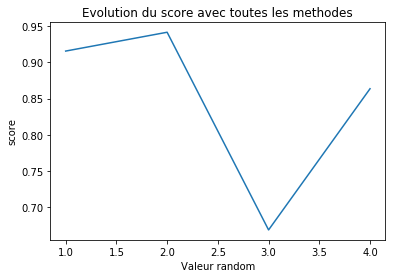

In [69]:
# A vous

from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# Puis : Commande uniquement Notebook : permet l'affichage des courbes
%matplotlib inline     
score = []
reussite_knn =[]

reussite_DT =[]

reussite_P =[]

reussite_rbf =[]
y = []

#  Cross-validation pour chaque  classifieur  sur l échantillon test
#1 knn
clf_knn=nn.KNeighborsClassifier(n_neighbors=4)
clf_knn.fit(X_train, y_train)
s1 = clf_knn.score(X_test, y_test)

reussite_knn = cross_val_score(clf_knn, X_train, y_train, cv = 10)
reussite_knn_std = reussite_knn.std()

#2 DecisionTreeClassifier()

clf_DT = DecisionTreeClassifier(max_depth=15)
clf_DT.fit(X_train, y_train)
s2 = clf_DT.score(X_test, y_test)

reussite_DT = cross_val_score(clf_DT, X_train, y_train, cv = 10)
reussite_DT_std = reussite_DT.std()
#3

clf_P = Perceptron(max_iter=828)
clf_P.fit(X_train, y_train)
s3 = clf_P.score(X_test, y_test)

reussite_P = cross_val_score(clf_P, X_train, y_train, cv = 10)
reussite_P_std = reussite_P.std()

#4

clf_rbf = SVC(kernel='rbf',gamma=0.3)
clf_rbf.fit(X_train, y_train)
s4 = clf_rbf.score(X_test, y_test)

reussite_rbf = cross_val_score(clf_rbf, X_train, y_train, cv = 10)
reussite_rbf_std = reussite_rbf.std()

score =[s1 , s2 ,s3 ,s4]  

y =[1,2,3,4]

plt.figure()
plt.plot(y,score)
plt.title("Evolution du score avec toutes les methodes")
plt.xlabel("Valeur random")
plt.ylabel("score")
plt.show()



In [46]:
score

[0.9155844155844156,
 0.9415584415584416,
 0.6688311688311688,
 0.8636363636363636]

In [ ]:
# donc meilleur methode  qui à le score s2  clf_DT = DecisionTreeClassifier(max_depth=15)

Pour chacune des méthodes, pour chaque meilleur hyperparamètre, calculer l'intervalle à 95% de confiance auquel le score doit appartenir en utilisant les résultats de la validation croisée. Si vous ne vous souvenez plus de comment on calcule un interval de confiance, vous pouvez consulter : https://fr.wikihow.com/calculer-un-intervalle-de-confiance

In [ ]:
# A vous
# Calculez l’écart-type de la population (σ) et la taille de l’échantillon (n).  * le z score
# on a 95 %	  donc  z score 1,96

In [80]:
import math

n= len(X)
d =math.sqrt( n )
ref = 1.96
p = 0.95
zs = p * ref

m1 = (reussite_knn_std/d) * zs
m2 = (reussite_DT_std/d)  * zs
m3 = (reussite_P_std/d) * zs
m4 = (reussite_rbf_std) * zs

In [81]:
print(m1,m2,m3,m4)

0.0018111326751883915 0.0017781473991336798 0.002106763497971667 0.0646145612121795


Quelle méthodes est la meilleure pour prédire la classe de frais de chauffage ? De frais de climatisation ?

In [ ]:
#on peut dire que la meilleur methode pour prédire   les deux classe ces la 4 eme methode 
#clf_rbf = SVC(kernel='rbf',gamma=0.3)
# puisque elle a un intervalle de confiance plus grand 